In [1]:
import pydub
import numpy as np
import matplotlib.pyplot as plt
import os

from dtaidistance import dtw
from scipy.signal import argrelextrema, find_peaks
from scipy.spatial.distance import cosine

import pandas as pd
import seaborn as sns

In [2]:
SOUND_FRAME_RATE=40000

## Playground

In [3]:
def get_audio_sample(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)
    return audio_sample

In [4]:
def get_audio_prompt(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)[int(sound.frame_rate*(4/3)**2*8):]
    return audio_sample

In [5]:
def downsample_signal(signal, block_num):
    resulting_signal = np.zeros(block_num + 1)
    nonzero_indices = np.nonzero(signal)[0] // (len(signal) // block_num + 1)
    resulting_signal[nonzero_indices] = 1
    return resulting_signal

## Scoring Procedure

In [6]:
def master_scoring_procedure(participant_response, answer_addr):
    participant_sample = get_audio_sample(participant_response)
    answer_sample = get_audio_prompt(answer_addr)
    
    participant_signal = np.where(participant_sample > 0.1 * np.max(participant_sample), 1.0, 0)
    participant_nonzero_indices = np.nonzero(participant_signal)[0]
    participant_signal = participant_signal[participant_nonzero_indices[0]:participant_nonzero_indices[-1] + 1]
    
    answer_signal = np.where(answer_sample[:int(44100 * 4/3 * 8)] > 800, 1, 0)
    answer_nonzero_indices = np.nonzero(answer_signal)[0]
    answer_signal = answer_signal[answer_nonzero_indices[0]:answer_nonzero_indices[-1] + 1]
    
    participant_downsample = downsample_signal(participant_signal, 500)
    true_sample_downsample = downsample_signal(answer_signal, 500)
    return cosine(participant_downsample, true_sample_downsample)

In [7]:
all_participants = os.listdir("./participant_data/")
scoring_basis_files = [
    f"../generated_beats/compiled_mp3/{file_name}"
    for file_name in os.listdir("../generated_beats/compiled_mp3/")
    if "practice" not in file_name
]
full_scoring_data = {
    "trial_source": [],
    "signal_similarities": [],
    "participant_ID": []
}
for participant in all_participants[:]:
    if participant == "22-J-13-SUR": continue
    participant_response_addresses = {
        file_name.split(".")[0]: f"./participant_data/{participant}/{file_name}"
        for file_name in os.listdir(f"./participant_data/{participant}/")
    }
    scoring_file_addresses = {
        "night_1_trial_1": scoring_basis_files[9],
        "night_1_trial_2": scoring_basis_files[10],
        "night_1_trial_3": scoring_basis_files[11],
        "night_2_trial_1": scoring_basis_files[12],
        "night_2_trial_2": scoring_basis_files[13],
        "night_2_trial_3": scoring_basis_files[14],
        "night_3_trial_1": scoring_basis_files[15],
        "night_3_trial_2": scoring_basis_files[16],
        "night_3_trial_3": scoring_basis_files[17],
        "morning_2_trial_1": scoring_basis_files[3],
        "morning_2_trial_2": scoring_basis_files[4],
        "morning_2_trial_3": scoring_basis_files[5],
        "morning_3_trial_1": scoring_basis_files[6],
        "morning_3_trial_2": scoring_basis_files[7],
        "morning_3_trial_3": scoring_basis_files[8]
    }
    if "morning_1" in list(participant_response_addresses.keys())[0]:
        participant_response_addresses.update(
            {
                "morning_2_trial_1": participant_response_addresses.pop("morning_1_trial_1"),
                "morning_2_trial_2": participant_response_addresses.pop("morning_1_trial_2"),
                "morning_2_trial_3": participant_response_addresses.pop("morning_1_trial_3"),
                "morning_3_trial_1": participant_response_addresses["morning_2_trial_1"],
                "morning_3_trial_2": participant_response_addresses["morning_2_trial_2"],
                "morning_3_trial_3": participant_response_addresses["morning_2_trial_3"]
            }
        )
        scoring_file_addresses.update(
            {
                "morning_2_trial_1": scoring_basis_files[0],
                "morning_2_trial_2": scoring_basis_files[1],
                "morning_2_trial_3": scoring_basis_files[2],
                "morning_3_trial_1": scoring_basis_files[3],
                "morning_3_trial_2": scoring_basis_files[4],
                "morning_3_trial_3": scoring_basis_files[5]
            }
        )
    first_morning = None
    for trial_source in participant_response_addresses.keys():
        full_scoring_data["participant_ID"].append(participant)
        full_scoring_data["trial_source"].append(trial_source)
        if first_morning is None and "morning" in trial_source:
            first_morning = trial_source[:9]
        if "morning" in trial_source:
            if first_morning in trial_source:
                signal_sim = max(
                    master_scoring_procedure(
                        participant_response_addresses[trial_source],
                        scoring_basis_files[int(trial_source[-1]) - 1]
                    ),
                    master_scoring_procedure(
                        participant_response_addresses[trial_source],
                        scoring_basis_files[int(trial_source[-1]) - 1 + 3]
                    )
                )
            else:
                signal_sim = max(
                    master_scoring_procedure(
                        participant_response_addresses[trial_source],
                        scoring_basis_files[int(trial_source[-1]) - 1 + 3]
                    ),
                    master_scoring_procedure(
                        participant_response_addresses[trial_source],
                        scoring_basis_files[int(trial_source[-1]) - 1 + 6]
                    )
                )
        else:
            signal_sim = master_scoring_procedure(
                participant_response_addresses[trial_source],
                scoring_file_addresses[trial_source]
            )
        full_scoring_data["signal_similarities"].append(signal_sim)

In [8]:
def process_prompts(prompt_id):
    answer_sample = get_audio_prompt(scoring_basis_files[prompt_id])
    answer_signal = np.where(answer_sample[:int(44100 * 4/3 * 8)] > 800, 1, 0)
    answer_nonzero_indices = np.nonzero(answer_signal)[0]
    answer_signal = answer_signal[answer_nonzero_indices[0]:answer_nonzero_indices[-1] + 1]
    true_sample_downsample = downsample_signal(answer_signal, 500)
    return true_sample_downsample

def run_one_attempt(processed_prompts):
    random_trials = [
        np.random.randint(0, 2, 501)
        for _ in range(3)
    ]
    cosine_sims = [
        cosine(prompt, random_answer)
        for prompt, random_answer in zip(processed_prompts, random_trials)
    ]
    return cosine_sims

def run_one_bootstrap(next_phase, n_iters=500000):
    current_phase_prompts, next_phase_prompts = [], []
    if next_phase == "morning_2":
        current_phase_prompts = [9, 10, 11]
        next_phase_prompts = [0, 1, 2]
    if next_phase == "night_2":
        current_phase_prompts = [9, 10, 11]
        next_phase_prompts = [0, 1, 2]
    if next_phase == "morning_3":
        current_phase_prompts = [9, 10, 11]
        next_phase_prompts = [0, 1, 2]
    if next_phase == "night_3":
        current_phase_prompts = [9, 10, 11]
        next_phase_prompts = [0, 1, 2]
    statistics = []
    current_phase_prompts = [
        process_prompts(prompt_id)
        for prompt_id in current_phase_prompts
    ]
    next_phase_prompts = [
        process_prompts(prompt_id)
        for prompt_id in next_phase_prompts
    ]
    for _ in range(n_iters):
        statistics.append(
            np.mean(run_one_attempt(next_phase_prompts)) - np.mean(run_one_attempt(current_phase_prompts))
        )
    return statistics

0.001548

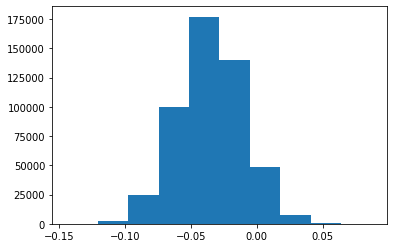

In [9]:
bootstrap_result = run_one_bootstrap("morning_2")
plt.hist(bootstrap_result)
np.mean(np.array(bootstrap_result) > 0.0378)

0.005418

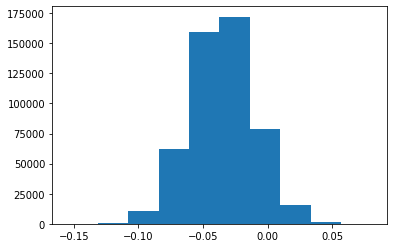

In [10]:
bootstrap_result = run_one_bootstrap("night_2")
plt.hist(bootstrap_result)
np.mean(np.array(bootstrap_result) < -0.097676)

1.2e-05

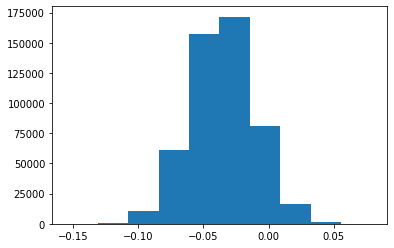

In [11]:
bootstrap_result = run_one_bootstrap("morning_3")
plt.hist(bootstrap_result)
np.mean(np.array(bootstrap_result) > 0.066836)

0.466404

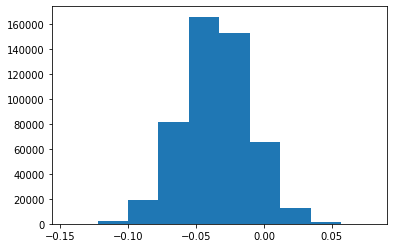

In [12]:
bootstrap_result = run_one_bootstrap("night_3")
plt.hist(bootstrap_result)
np.mean(np.array(bootstrap_result) < -0.037114)

## Analysis Stage

In [13]:
everyone_score = pd.DataFrame(data=full_scoring_data)
everyone_score["trial_source_abbrev"] = everyone_score["trial_source"].apply(lambda x: x.split("_trial")[0])
def get_PSQI_attached_responses(form_id):
    PSQI_responses = pd.read_csv(f"../PSQI/exported-PSQI-{form_id}.csv")
    morning_id = 2 if form_id == "b" else 3
    everyone_score_With_PSQI_b = everyone_score.merge(
        right=PSQI_responses,
        left_on="participant_ID",
        right_on="participant_ID"
    ).query(f"trial_source_abbrev=='morning_{morning_id}'")
    everyone_score_With_PSQI_b = everyone_score_With_PSQI_b.drop(
        columns=["trial_source", "trial_source_abbrev", "participant_ID", "Unnamed: 0"]
    )
    everyone_score_With_PSQI_b = everyone_score_With_PSQI_b + np.random.normal(0, 1e-12, everyone_score_With_PSQI_b.shape)
    everyone_score_With_PSQI_b = everyone_score_With_PSQI_b.set_axis(
        ["Tapping Similarity", "Subjective SQ", "Sleep Latency", "Sleep Duration", "Sleep Efficiency", "Sleep Disturbance", "Use of Sleep Medication", "Daytime Dysfunction", "PSQI Index"],
        axis=1   
    )
    return everyone_score_With_PSQI_b

everyone_score_With_PSQI_b = get_PSQI_attached_responses("b")
everyone_score_With_PSQI_c = get_PSQI_attached_responses("c")

In [14]:
constructing_data = {
    "userID": [],
    "proceeding_phase": [],
    "change_in_mean": []
}
for user_ID in everyone_score["participant_ID"]:
    time_indices = ["night_1", "morning_2", "night_2", "morning_3", "night_3"]
    for i in range(len(time_indices) - 1):
        constructing_data["userID"].append(user_ID)
        constructing_data["proceeding_phase"].append(time_indices[i + 1])
        constructing_data["change_in_mean"].append(
            everyone_score\
                .query(f"participant_ID=='{user_ID}'")\
                .query(f"trial_source_abbrev=='{time_indices[i + 1]}'")\
                ["signal_similarities"].mean()
             - everyone_score\
                .query(f"participant_ID=='{user_ID}'")\
                .query(f"trial_source_abbrev=='{time_indices[i]}'")\
                ["signal_similarities"].mean()
        )

In [44]:
def PSQI_attached_changes(form_id):
    PSQI_responses = pd.read_csv(f"../PSQI/exported-PSQI-{form_id}.csv")
    morning_id = 2 if form_id == "b" else 3
    thing = pd.DataFrame(constructing_data).merge(
        right=PSQI_responses,
        left_on="userID",
        right_on="participant_ID"
    ).query(f"proceeding_phase=='morning_{morning_id}'")
    thing = thing.drop(
        columns=["proceeding_phase", "participant_ID", "Unnamed: 0", "userID"]
    )
    thing = thing + np.random.normal(0, 1e-12, thing.shape)
    thing = thing.set_axis(
        ["Change in Average Cosine", "Subjective SQ", "Sleep Latency", "Sleep Duration", "Sleep Efficiency", "Sleep Disturbance", "Use of Sleep Medication", "Daytime Dysfunction", "PSQI Index"],
        axis=1   
    )
    return thing

Text(0.5, 1.0, 'Correlation Matrix between PSQI Subcomponent Scores \n with Rhythm Task Performance on Subsequent Morning')

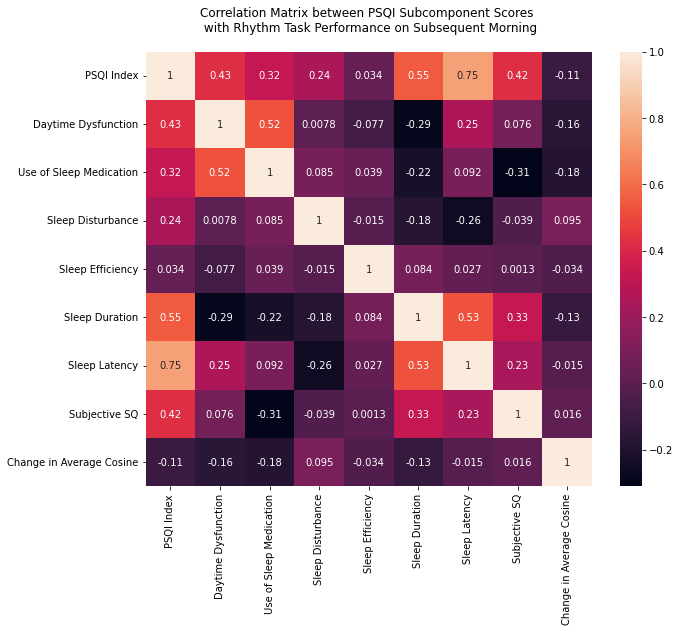

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    pd.concat(
        [PSQI_attached_changes("b"), PSQI_attached_changes("c")]
    ).iloc[:, ::-1].corr(),
    annot=True
)
plt_title = "Correlation Matrix between PSQI Subcomponent Scores \n with Rhythm Task Performance on Subsequent Morning"
ax.set_title(plt_title, pad=20)

Text(0, 0.5, 'Change of Cosine Similarity of Prompt and Participant Response')

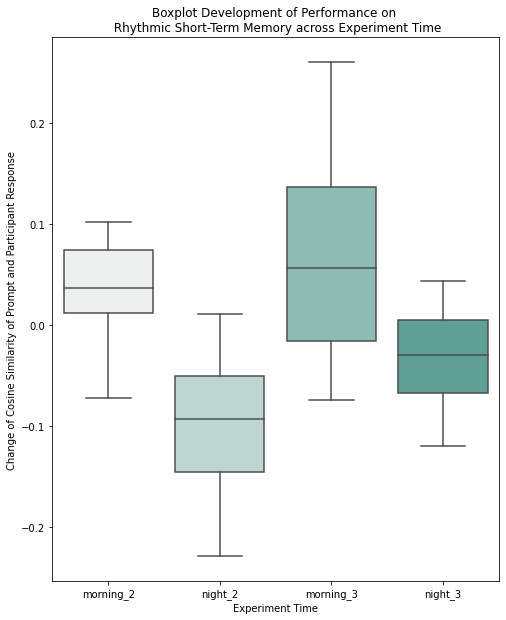

In [25]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(
    data=pd.DataFrame(constructing_data),
    x="proceeding_phase",
    y="change_in_mean",
    order=["morning_2", "night_2", "morning_3", "night_3"],
    palette="light:#5A9"
)
plt.title("Boxplot Development of Performance on \n Rhythmic Short-Term Memory across Experiment Time")
plt.xlabel("Experiment Time")
plt.ylabel("Change of Cosine Similarity of Prompt and Participant Response")

Text(0.5, 1.0, 'Correlation Matrix between PSQI Subcomponent Scores \n with Rhythm Task Performance on Subsequent Morning')

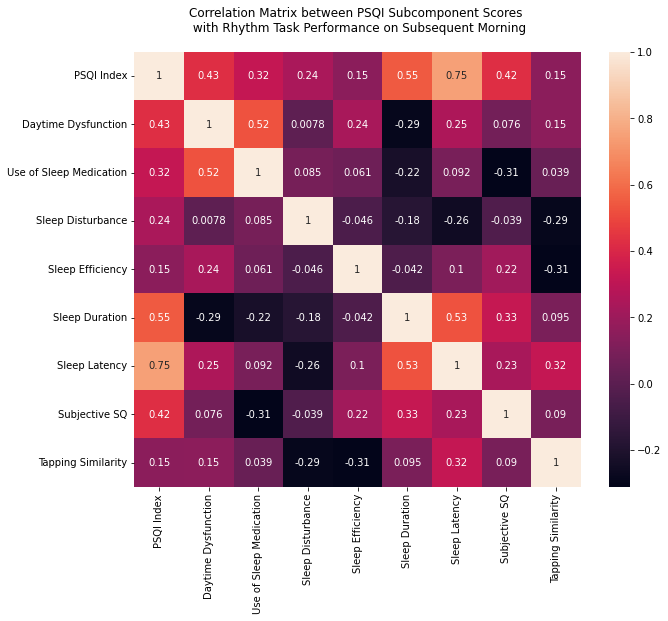

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    pd.concat(
        [everyone_score_With_PSQI_b, everyone_score_With_PSQI_c]
    ).iloc[:, ::-1].corr(),
    annot=True
)
plt_title = "Correlation Matrix between PSQI Subcomponent Scores \n with Rhythm Task Performance on Subsequent Morning"
ax.set_title(plt_title, pad=20)

Text(0.5, 1.0, 'Correlation Matrix between PSQI Subcomponent Scores on Form C with Rhythm Task Performance on Morning 3')

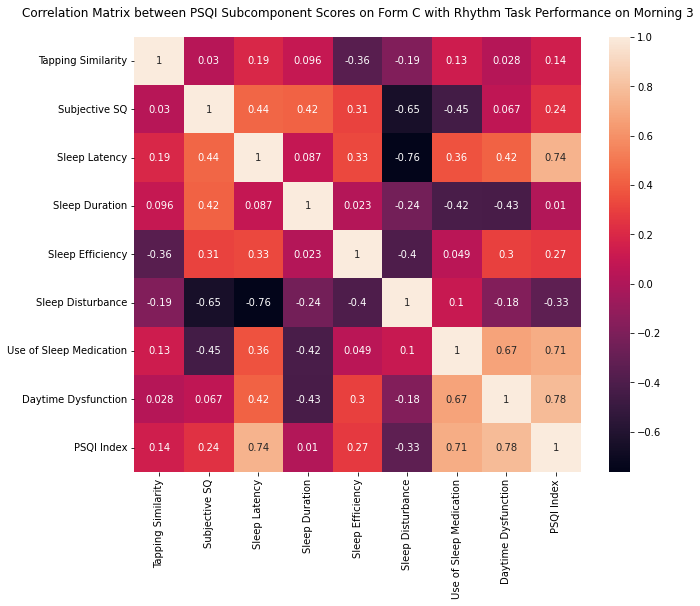

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    everyone_score_With_PSQI_c.corr(),
    annot=True
)
plt_title = "Correlation Matrix between PSQI Subcomponent Scores on Form C with Rhythm Task Performance on Morning 3"
ax.set_title(plt_title, pad=20)

Text(0, 0.5, 'Cosine Similarity of Prompt and Participant Response')

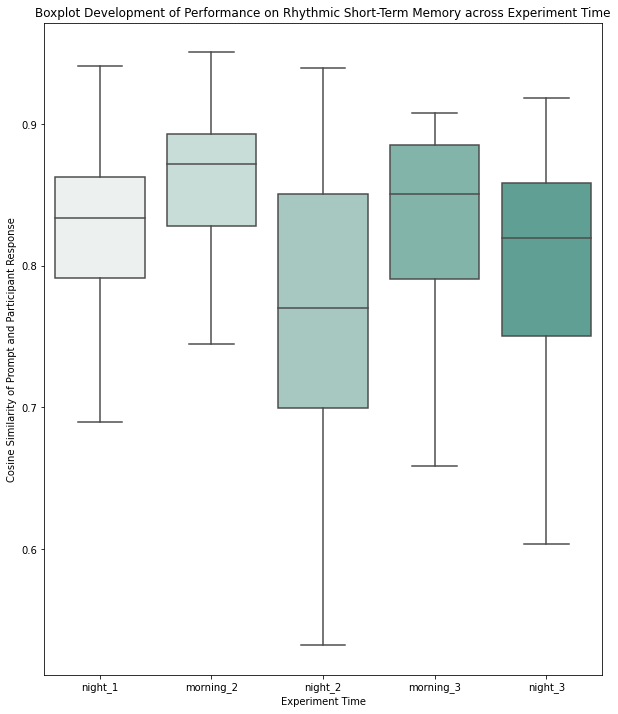

In [24]:
fig, ax = plt.subplots(figsize=(10, 12))
sns.boxplot(
    data=everyone_score,
    x="trial_source_abbrev",
    y="signal_similarities",
    order=["night_1", "morning_2", "night_2", "morning_3", "night_3"],
    palette="light:#5A9"
)
plt.title("Boxplot Development of Performance on Rhythmic Short-Term Memory across Experiment Time")
plt.xlabel("Experiment Time")
plt.ylabel("Cosine Similarity of Prompt and Participant Response")

In [19]:
# everyone_score.query("trial_source_abbrev=='morning_3'").groupby("participant_ID").agg({"signal_similarities": "mean"})